# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

В данном шаге необходимо провести исследовательский анализ данных:
- посмотреть на размер выборки;
- построить график распределения возраста в выборке;
- напечатать на экране 10–15 фотографий.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


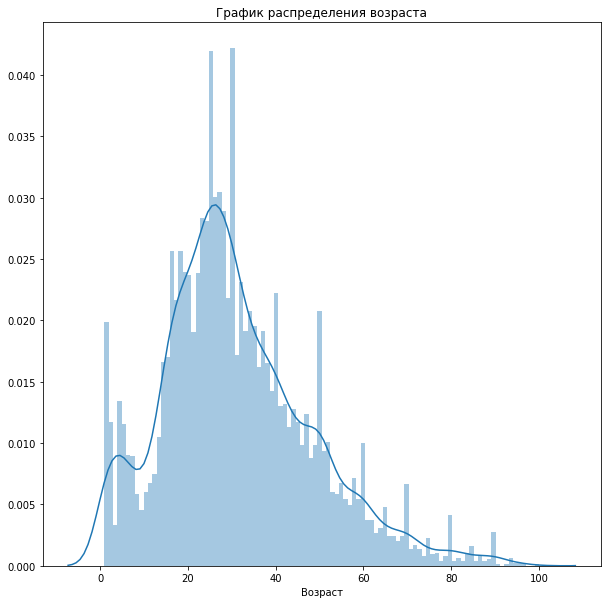

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.distplot(labels['real_age'], ax=ax, bins=100)
ax.set_title('График распределения возраста')
ax.set_xlabel('Возраст')
plt.show()

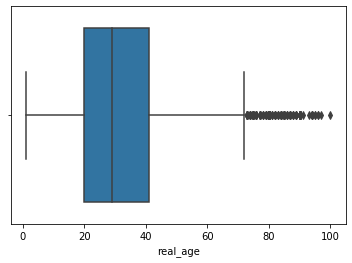

In [4]:
sns.boxplot(labels["real_age"])

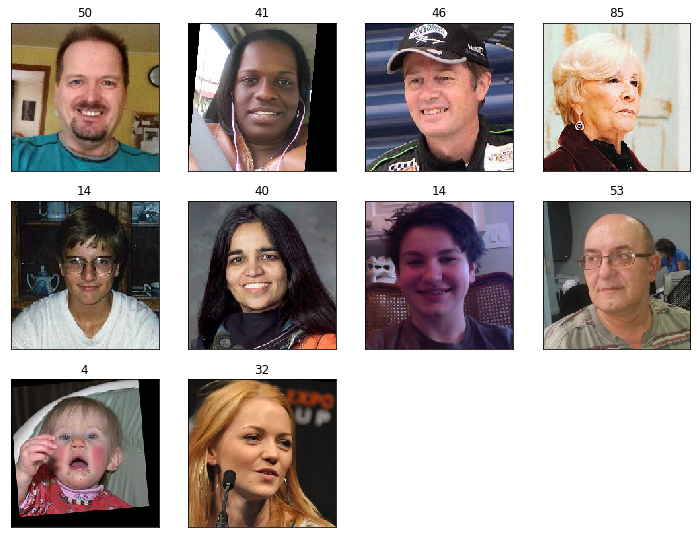

In [5]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])

Выборка состоит из 7591 изображений разного размера, которые приведены к квадратным, размером 224x224.

Из графика и фотографий видим, что в датасете есть фотографии людей разного возраста от года до 100 лет. Наибольшее количество находится в промежутке 20-30 лет. Некоторые фотографии повернуты, уменьшены или увеличены в размере так, чтобы лица были расположены ровно, одинаково. 

Из гистограммы и боксплота видно, что после 70 лет - выбросы. В круглые даты (30, 40, 50, 60, 70, 80, 90) можно увидеть пики, которые можно объяснить тем, что возраст округлили к ближайшей круглой дате.

## Обучение модели

Код обучения модели и её результат вывода на экран:


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255) 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False) 
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2) 
 
    return model

```

```

Результат вывода на экран:

Train for 178 steps, validate for 60 steps
Epoch 1/5
2022-01-23 07:23:53.167630: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-23 07:23:56.287925: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 69s - loss: 236.4439 - mae: 11.0364 - val_loss: 936.5677 - val_mae: 25.7978
Epoch 2/5
178/178 - 37s - loss: 72.3053 - mae: 6.3901 - val_loss: 738.7645 - val_mae: 22.1386
Epoch 3/5
178/178 - 37s - loss: 47.2486 - mae: 5.2386 - val_loss: 292.4711 - val_mae: 12.6531
Epoch 4/5
178/178 - 37s - loss: 34.7357 - mae: 4.5065 - val_loss: 109.7575 - val_mae: 7.9038
Epoch 5/5
178/178 - 37s - loss: 27.6081 - mae: 3.9481 - val_loss: 78.8420 - val_mae: 6.7148

60/60 - 9s - loss: 78.8420 - mae: 6.7148
Test MAE: 6.7148
```

## Анализ обученной модели

Функцией потерь было выбрано MAE (mean absolute error). Полученный результат с пятью эпохами на обучающей выборке равен 3.95, на тестовой - 6.72.

При обучении были созданы функции: 
- load_train(path),
- load_test(path),
- create_model(input_shape),
- train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps).